<a href="https://colab.research.google.com/github/ar851060/palm_detection_prediction/blob/main/CCBDA_final_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q qqdm

In [ ]:
import random
import torch


import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models

from torch.optim import Adam, AdamW

from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.vq import vq, kmeans

import pandas as pd

import pdb  # use pdb.set_trace() to set breakpoints for debugging

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import torchvision.transforms as transforms

from torch import nn
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import sys
import imutils
from scipy.stats import gaussian_kde
import re
import os
from tqdm.auto import tqdm
import math
import pandas as pd
from PIL import Image  
from qqdm import qqdm, format_str

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def img_to_array(img):
  return np.array(img)

def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

image_path = '/content/drive/Shareddrives/CCBDA_final/allHands'
img_array = []

sketch_path = '/content/drive/Shareddrives/CCBDA_final/allHands'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))
# sketch_file = [re.findall("[0-9BG]+",x)[0] for x in sketch_file if re.findall("mask",x)]
# image_file = [re.findall("[0-9BG]+",x)[0] for x in image_file if re.findall("[0-9BG]+",x)]
# files = list(set(image_file) & set(sketch_file))

In [ ]:
for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    img_array.append(img_to_array(image))
    # Image Augmentation
    
    # # horizontal flip 
    # img1 = cv2.flip(image,1)
    # img_array.append(img_to_array(img1))
    #  #vertical flip 
    # img2 = cv2.flip(image,-1)
    # img_array.append(img_to_array(img2))
    #  #vertical flip 
    # img3 = cv2.flip(image,-1)
    # # horizontal flip
    # img3 = cv2.flip(img3,1)
    # img_array.append(img_to_array(img3))
    # # rotate clockwise 
    # img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    # img_array.append(img_to_array(img4))
    # # flip rotated image 
    # img5 = cv2.flip(img4,1)
    # img_array.append(img_to_array(img5))
    #  # rotate anti clockwise 
    # img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    # img_array.append(img_to_array(img6))
    # # flip rotated image 
    # img7 = cv2.flip(img6,1)
    # img_array.append(img_to_array(img7))
  
    
for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))
    
    # #Image Augmentation
    # # horizontal flip 
    # img1 = cv2.flip(image,1)
    # sketch_array.append(img_to_array(img1))
    #  #vertical flip 
    # img2 = cv2.flip(image,-1)
    # sketch_array.append(img_to_array(img2))
    #  #vertical flip 
    # img3 = cv2.flip(image,-1)
    # # horizontal flip
    # img3 = cv2.flip(img3,1)
    # sketch_array.append(img_to_array(img3))
    # # rotate clockwise 
    # img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    # sketch_array.append(img_to_array(img4))
    # # flip rotated image 
    # img5 = cv2.flip(img4,1)
    # sketch_array.append(img_to_array(img5))
    #  # rotate anti clockwise 
    # img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    # sketch_array.append(img_to_array(img6))
    # # flip rotated image 
    # img7 = cv2.flip(img6,1)
    # sketch_array.append(img_to_array(img7))

  0%|          | 0/1442 [00:00<?, ?it/s]

  0%|          | 0/1442 [00:00<?, ?it/s]

In [ ]:
train_sketch_image = sketch_array[:1400]
train_image = img_array[:1400]
test_sketch_image = sketch_array[1400:]
test_image = img_array[1400:]
total_image = sketch_array
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
total_image= np.reshape(total_image, (len(total_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)

Train color image shape: (1400, 256, 256, 3)
Test color image shape (42, 256, 256, 3)


In [ ]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(19530615)

In [ ]:
# maybe it can be smaller
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),        
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.Conv2d(48, 96, 4, stride=2, padding=1),   # medium: remove this layer
            nn.ReLU(),
            
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1), # medium: remove this layer
            nn.ReLU(),
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
            # nn.Sigmoid()
        )

    def forward(self, x):
        en_x = self.encoder(x)
        de_x = self.decoder(en_x)
        return en_x, de_x

In [ ]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
                            transforms.Lambda(lambda x: x.to(torch.float32)),
                            #transforms.Lambda(lambda x: 2. * x/255. - 1.),
                            # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                            ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

In [ ]:
# Training hyperparameters
num_epochs = 200
batch_size = 256 # medium: smaller batchsize
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(train_image)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Build total image dataloader
x = torch.from_numpy(total_image)
total_dataset = CustomTensorDataset(x)

total_dataloader = DataLoader(total_dataset,shuffle = False, batch_size=batch_size)

# Model
model_type = 'cnn'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes ='cnn':conv_autoencoder()
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

In [ ]:
best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = list()
    for data in train_dataloader:

        # ===================loading=====================
        if model_type in ['cnn', 'vae', 'resnet']:
            img = data.float().cuda()
        elif model_type in ['fcn']:
            img = data.float().cuda()
            img = img.view(img.shape[0], -1)

        # ===================forward=====================
        #img = img.view(img.shape[0], -1)
        _ , output = model(img)
        #print(output.shape)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
      'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
      'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))
    #torch.save(model, 'last_model.pt')


 Iters    Elapsed Time      Speed                                               
 0/200          -             -                                                 
Description   0.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 1/200  00:00:02<00:08:22  0.40it/s  1/200  0.3559                              
Description   0.5% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 2/200  00:00:04<00:07:30  0.44it/s  2/200  0.3142                              
Description   1.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 3/200  00:00:06<00:07:11  0.46it/s  3/200  0.1843                              
Description   1.5% |                                                           | Iters    Elapsed Time      Spee

In [ ]:
eval_batch_size = 200

# build testing dataloader
# data = torch.tensor(test_image, dtype=torch.float32)
# test_dataset = CustomTensorDataset(data)
# test_sampler = SequentialSampler(test_dataset)
# test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1)
# eval_loss = nn.MSELoss(reduction='none')

# build total dataloader
# data_total = torch.tensor(total_image, dtype=torch.float32)
# total_dataset = CustomTensorDataset(data_total) 
# total_dataloader = DataLoader(total_dataset,shuffle = False , batch_size=eval_batch_size, num_workers=1)

# load trained model
# checkpoint_path = 'last_model_cnn.pt'
checkpoint_path = '/content/drive/Shareddrives/CCBDA_final/best_model_cnn.pt'
model = torch.load(checkpoint_path)
model.eval()




conv_autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)

In [ ]:
import os
folder = "/content/drive/Shareddrives/CCBDA_final/allHands"
filenames = os.listdir(folder)
idx = 0

emb = []

with torch.no_grad():


  for i, x in enumerate(total_dataloader): 
        img = x.float().cuda()
        embbeding, output = model(img)
        emb.append(embbeding)  

        # for e in embbeding:
        #   name = filenames[idx]
        #   e = e.flatten().cpu().numpy()
        #   np.save("/content/drive/Shareddrives/CCBDA_final/Emb/"+name[:-4],e)
        #   idx += 1     

        # loss = eval_loss(output, img).sum([1, 2, 3])

  
emb = torch.cat(emb, dim = 0)
emb = emb.flatten(start_dim = 1).cpu().detach().numpy()
#embbeding = embbeding.flatten().cpu().numpy()
np.save('/content/drive/Shareddrives/CCBDA_final/Autoencoder_total_emb/emb',emb)

# embbeding.shape

In [ ]:
emb.shape

(1442, 24576)

In [ ]:
img.shape

torch.Size([120, 3, 256, 256])

In [ ]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("sketch",fontsize = 15, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

In [ ]:
output.shape

torch.Size([120, 3, 256, 256])

In [ ]:
ts = transforms.Compose([
                            transforms.Lambda(lambda x: (x+1)*255.0/2.0),
                            transforms.Lambda(lambda x: x.to(torch.int)),
                            # transforms.Lambda(lambda x: 2. * x/255. - 1.),
                            # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                            ])

In [ ]:
op = ts(output).permute(0,2,3,1).cpu().numpy()

op.shape
#np.save("0850740",op)

(120, 256, 256, 3)

In [ ]:
output = output[0]

In [ ]:
op.shape

(120, 256, 256, 3)

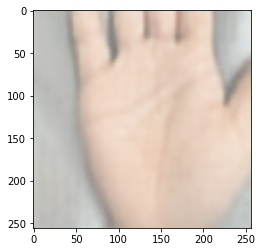

In [ ]:
plt.imshow(op[5,:,:,:])

In [ ]:
op.shape

(120, 256, 256, 3)

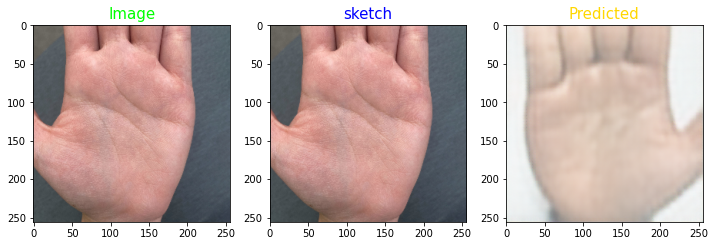

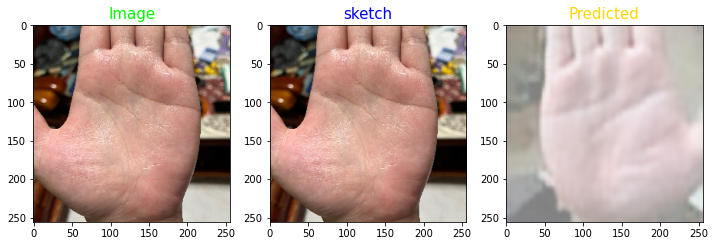

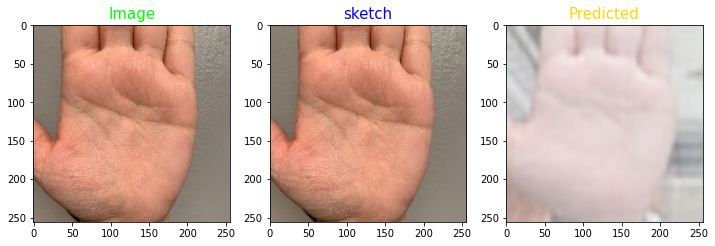

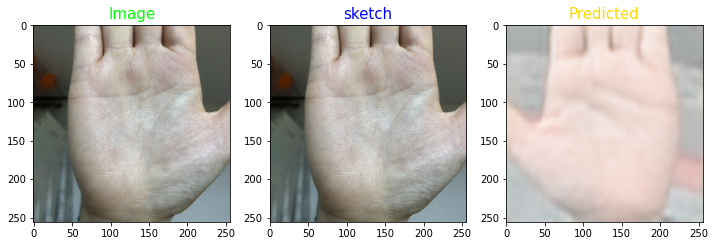

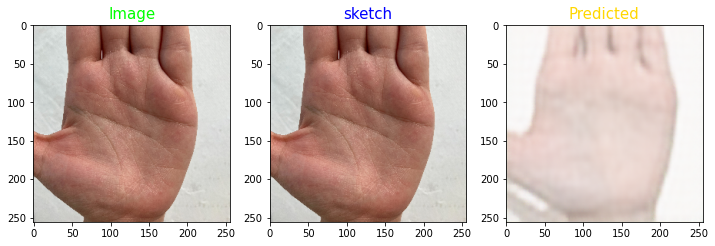

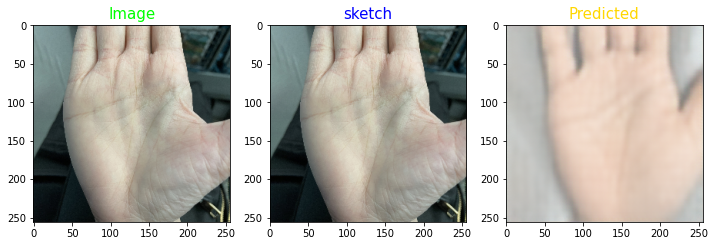

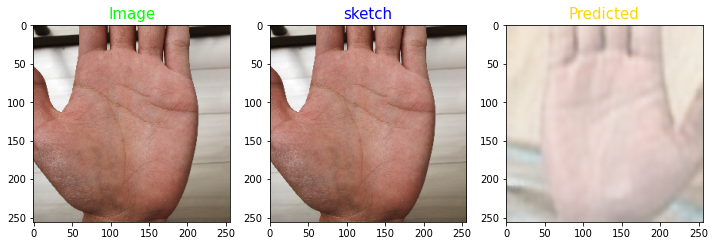

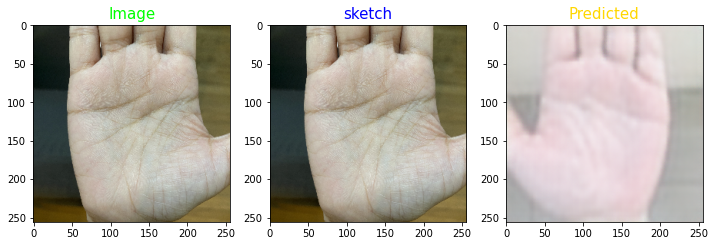

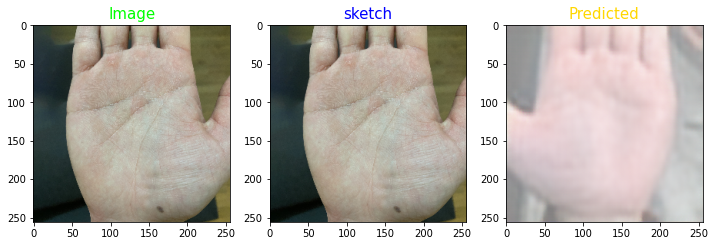

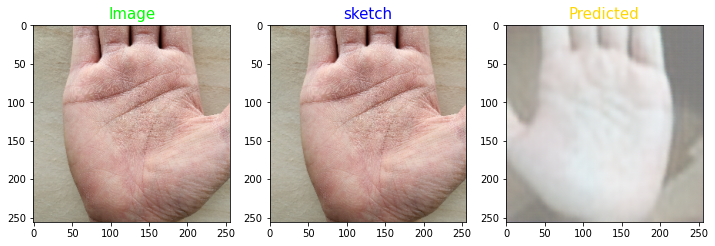

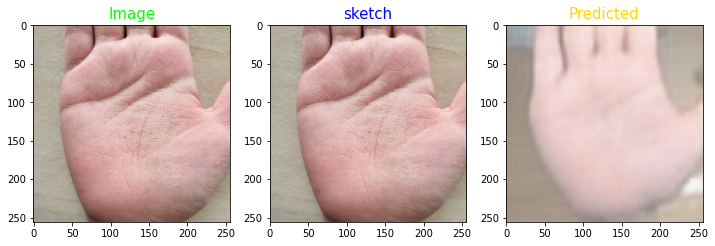

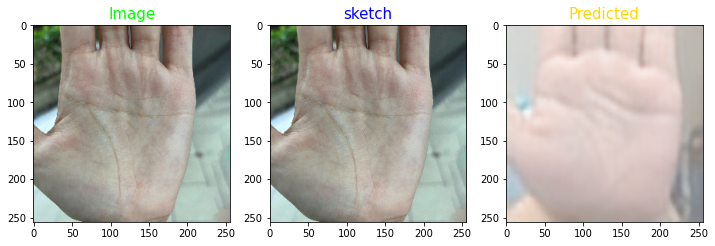

In [ ]:
ls = [i for i in range(0,12)]

for i in ls:
  ori = test_image[i]
  label = test_sketch_image[i]
  show_images(ori,label,op[i])